In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


#Prepare the Dataset and DataLoader


In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='/content/drive/MyDrive/DL/', train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root='/content/drive/MyDrive/DL/', train=False, transform=transform, download= False)

train_loader = DataLoader(dataset=train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=20, shuffle=False)





# Visualizing Images

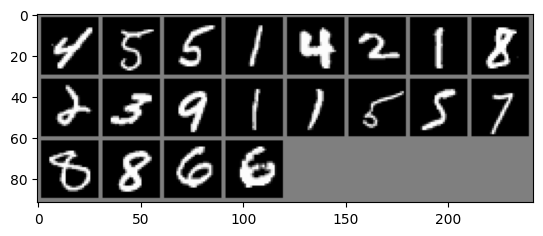

3 2 2 1 3 2 1 2 2 2 3 1 1 2 2 1 2 2 0 0


In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{labels[j].item()}' for j in range(20)))


# CNN Model

In [ ]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

        self._to_linear = None
        self._calculate_to_linear_size()
        self.fc = nn.Linear(self._to_linear, 10)

    def _calculate_to_linear_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)
            output = self.conv_forward(dummy_input)
            self._to_linear = output.numel()

    def conv_forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.avgpool(F.relu(self.conv3(x)))
        return x

    def forward(self, x):
        """ Forward pass through the entire network """
        x = self.conv_forward(x)
        x = x.view(-1, self._to_linear)  # Flatten the tensor
        x = self.fc(x)
        return x



# Initialize Model, Loss Function, and Optimizer

In [ ]:
model = CNN().to(device)
print(f"Size of input to fully connected layer: {model._to_linear}")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Size of input to fully connected layer: 16


In [ ]:

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            max, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

    return train_losses, train_accuracies

def evaluate_model(model, test_loader):
    correct, total = 0, 0
    all_labels = []
    all_predictions = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            max, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}%')
    return all_labels, all_predictions

# Function for plotting confusion matrix and training graphs
def plot_results(all_labels, all_predictions, train_losses, train_accuracies):
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Epoch [1/10], Loss: 0.4002, Accuracy: 86.97%
Epoch [2/10], Loss: 0.1340, Accuracy: 95.78%
Epoch [3/10], Loss: 0.1030, Accuracy: 96.76%
Epoch [4/10], Loss: 0.0891, Accuracy: 97.20%
Epoch [5/10], Loss: 0.0790, Accuracy: 97.50%
Epoch [6/10], Loss: 0.0720, Accuracy: 97.75%
Epoch [7/10], Loss: 0.0651, Accuracy: 97.89%
Epoch [8/10], Loss: 0.0611, Accuracy: 98.06%
Epoch [9/10], Loss: 0.0583, Accuracy: 98.16%
Epoch [10/10], Loss: 0.0548, Accuracy: 98.27%
Test Accuracy: 98.62%


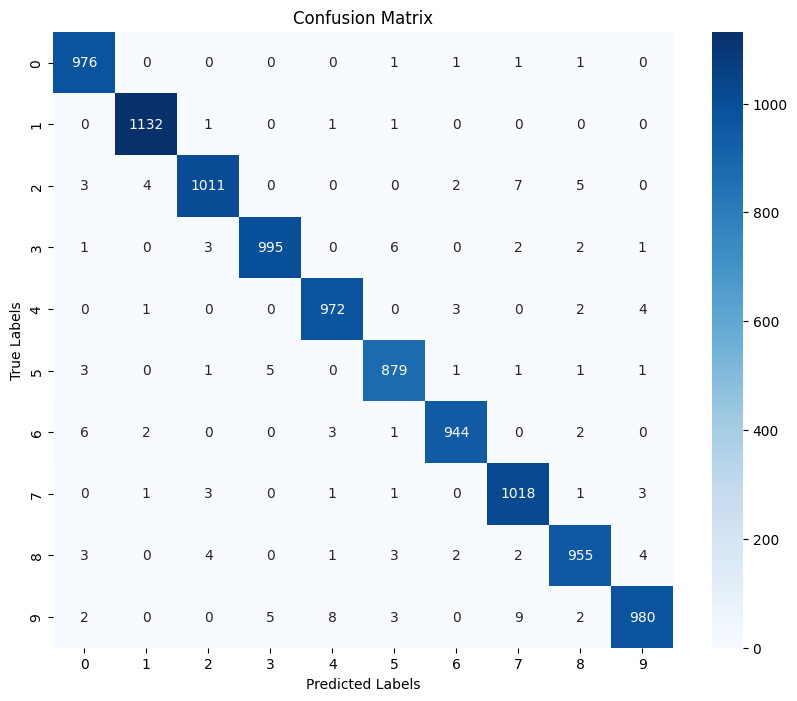

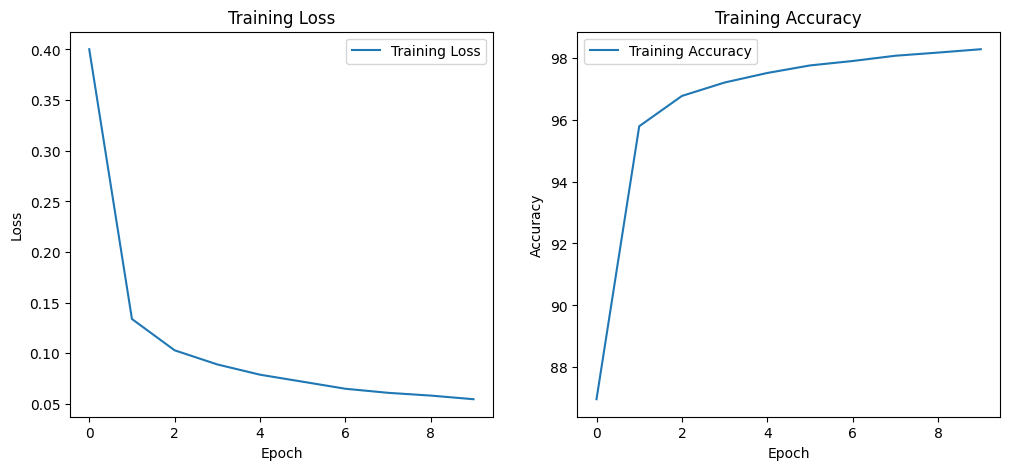

In [ ]:
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer)
all_labels, all_predictions = evaluate_model(model, test_loader)
plot_results(all_labels, all_predictions, train_losses, train_accuracies)


# Visualize Layer Output


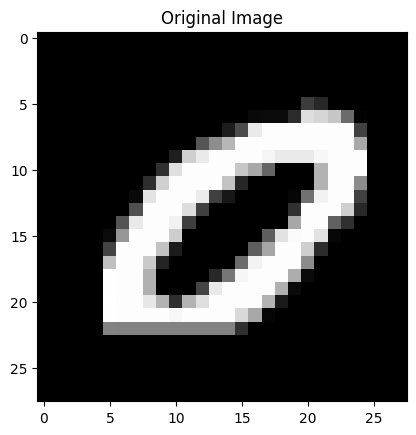

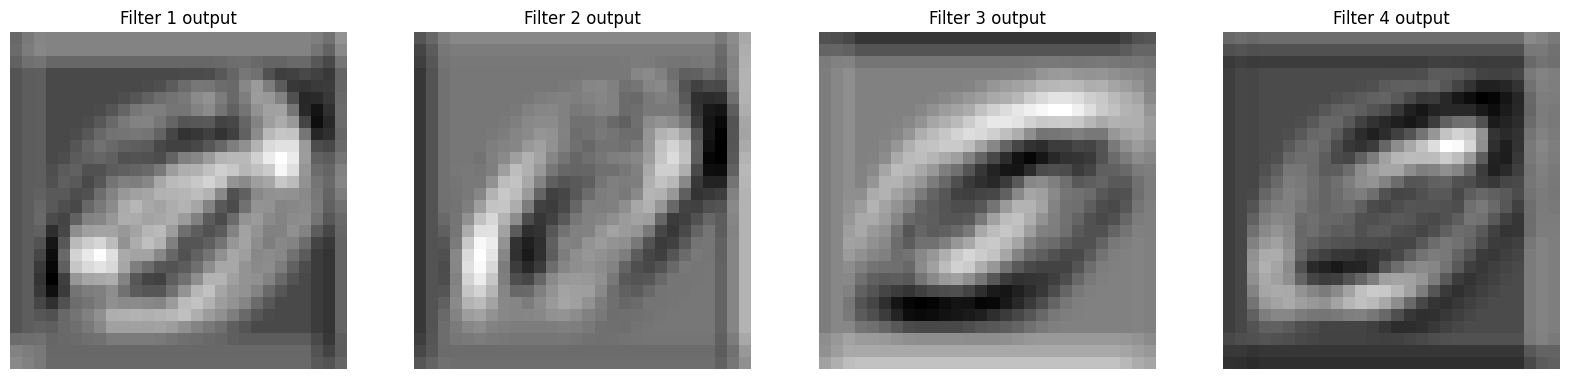

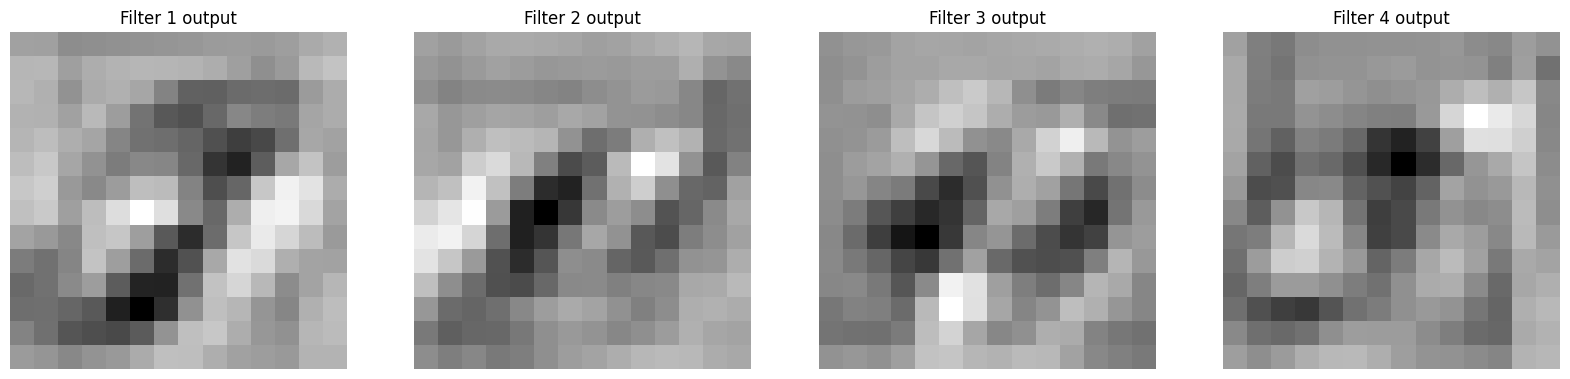

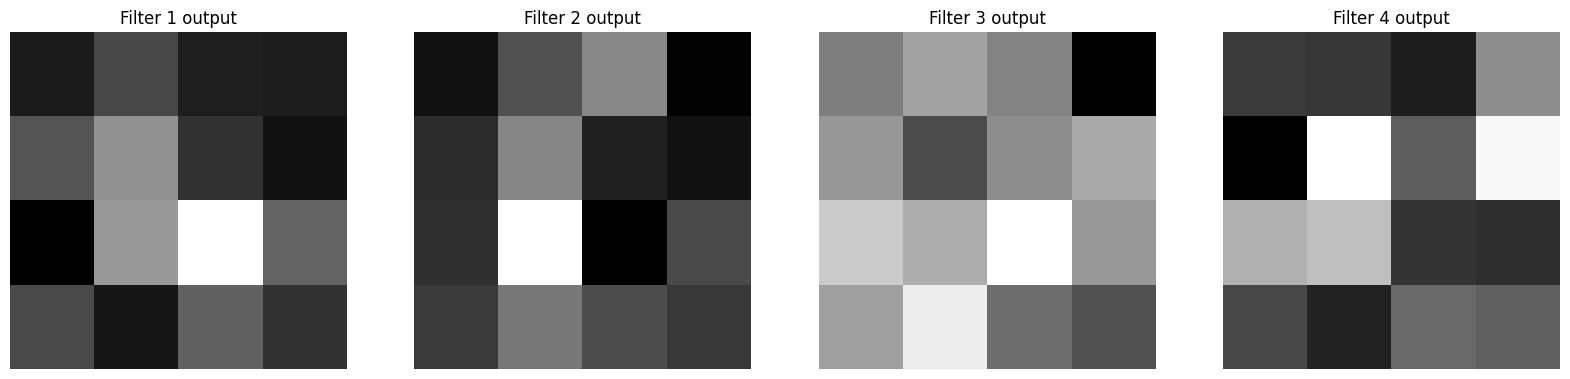

In [ ]:
def visualize_layer_output(model, layer, image, num_filters=4):

    model.eval()
    image = image.to(device)

    with torch.no_grad():
        if layer == 'conv1':
            output = model.conv1(image)
        elif layer == 'conv2':
            output = model.conv2(model.maxpool(F.relu(model.conv1(image))))
        elif layer == 'conv3':
            output = model.conv3(model.avgpool(F.relu(model.conv2(model.maxpool(F.relu(model.conv1(image)))))))
        else:
            raise ValueError("Layer not recognized")

    plt.figure(figsize=(20, 5))
    for i in range(num_filters):
        ax = plt.subplot(1, num_filters, i + 1)
        ax.imshow(output[0][i].cpu().detach().numpy(), cmap='gray')
        ax.set_title(f'Filter {i+1} output')
        ax.axis('off')
    plt.show()

sample_image, _ = next(iter(train_loader))
sample_image = sample_image[0:1]

plt.imshow(sample_image[0][0], cmap='gray')
plt.title("Original Image")
plt.show()

visualize_layer_output(model, 'conv1', sample_image)
visualize_layer_output(model, 'conv2', sample_image)
visualize_layer_output(model, 'conv3', sample_image)


# Error Analysis


In [ ]:
def error_analysis(all_predictions, all_labels):
  misclassified_idx = [idx for idx, (pred, label) in enumerate(zip(all_predictions, all_labels)) if pred != label]
  plt.figure(figsize=(15, 5))
  for i, idx in enumerate(misclassified_idx[:5]):
      image, label = test_dataset[idx]
      plt.subplot(1, 5, i + 1)
      plt.imshow(image.squeeze(), cmap='gray')
      plt.title(f'True: {label}, Pred: {all_predictions[idx]}')
      plt.axis('off')
  plt.show()


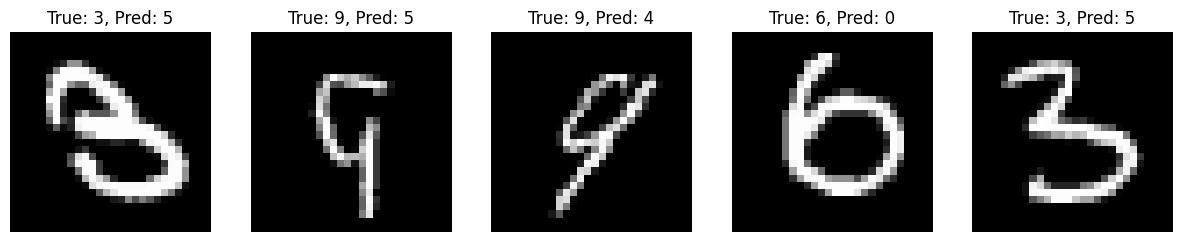

In [ ]:
error_analysis(all_predictions, all_labels)


In [ ]:
summary(model,(1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             800
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3            [-1, 8, 14, 14]           3,208
         MaxPool2d-4              [-1, 8, 7, 7]               0
            Conv2d-5              [-1, 4, 4, 4]             292
         AvgPool2d-6              [-1, 4, 2, 2]               0
            Linear-7                   [-1, 10]             170
Total params: 4,470
Trainable params: 4,470
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.02
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


# Feature Map Activation Across Layers




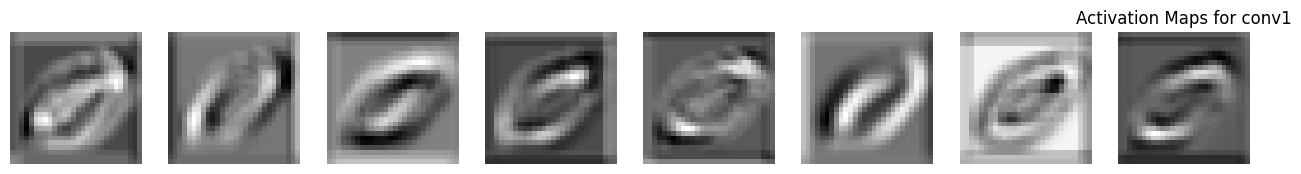

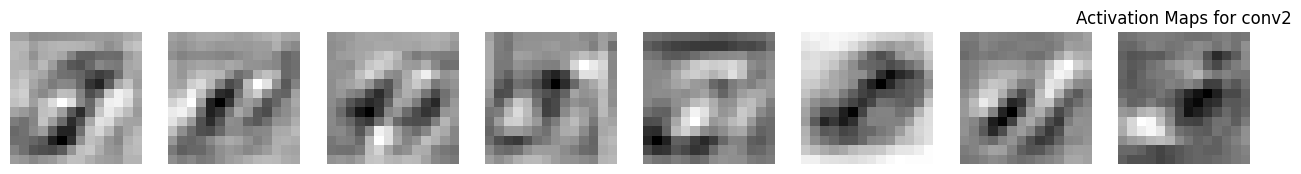

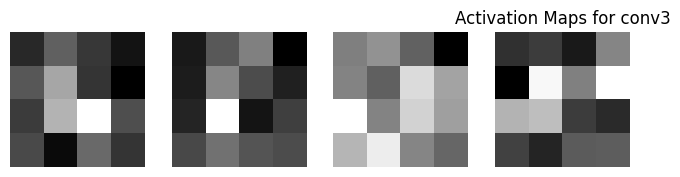

In [ ]:
def visualize_activation_maps(model, image):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    model.conv1.register_forward_hook(get_activation('conv1'))
    model.conv2.register_forward_hook(get_activation('conv2'))
    model.conv3.register_forward_hook(get_activation('conv3'))
    image = image.to(device)
    output = model(image)

    for layer_name in activation:
        act = activation[layer_name].squeeze().cpu()  # Move to CPU
        num_act = act.size(0)
        row_size = min(num_act, 8)
        fig, axes = plt.subplots(1, row_size, figsize=(row_size*2, 2))
        for i, ax in enumerate(axes):
            if i < row_size:
                ax.imshow(act[i].numpy(), cmap='gray')
                ax.axis('off')
        plt.title(f'Activation Maps for {layer_name}')
        plt.show()

visualize_activation_maps(model, sample_image)











#T-SNE Visualization of Feature Representations

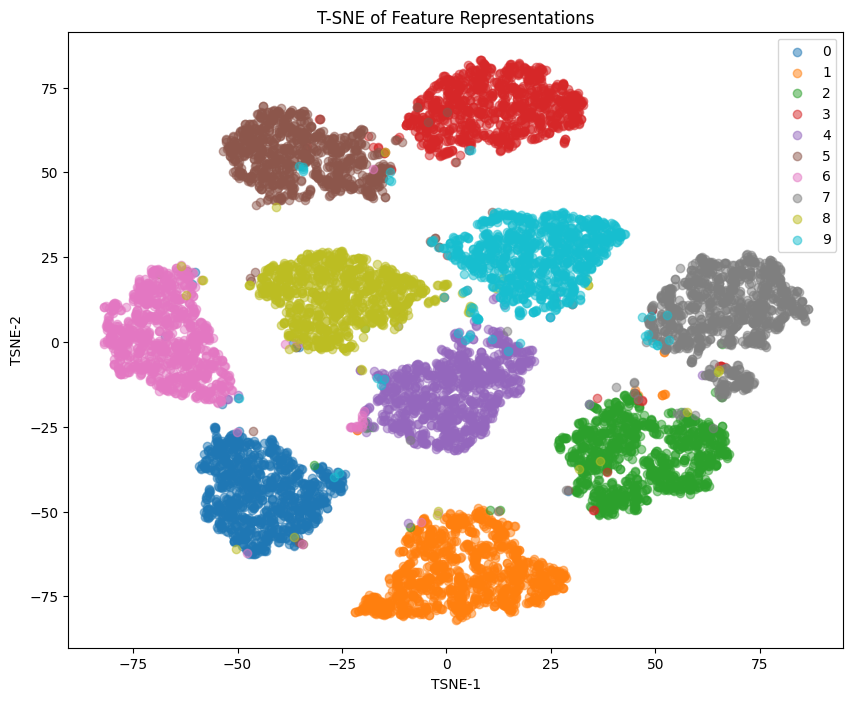

In [ ]:

def extract_features(test_loader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, label in test_loader:
            images = images.to(device)
            output = model(images)
            features.extend(output.cpu().numpy())
            labels.extend(label.cpu().numpy())
    return np.array(features), np.array(labels)

features, labels = extract_features(test_loader, model)

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
for label in range(10):
    indices = [i for i, l in enumerate(labels) if l == label]
    current_tsne = tsne_results[indices, :]
    plt.scatter(current_tsne[:, 0], current_tsne[:, 1], label=str(label), alpha=0.5)
plt.legend()
plt.title('T-SNE of Feature Representations')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.show()


# 4 image classes

In [ ]:
def reclassify_label(label):
    if label in [0, 6]:
        return 0
    elif label in [1, 7]:
        return 1
    elif label in [2, 3, 8, 5]:
        return 2
    elif label in [4, 9]:
        return 3
    else:
        raise ValueError("Invalid label")
train_dataset_4 = datasets.MNIST(root='/content/drive/MyDrive/DL/', train=True, transform=transform, download=False)
test_dataset_4 = datasets.MNIST(root='/content/drive/MyDrive/DL/', train=False, transform=transform, download= False)


train_dataset.targets = torch.tensor([reclassify_label(y) for y in train_dataset_4.targets])
test_dataset.targets = torch.tensor([reclassify_label(y) for y in test_dataset_4.targets])

train_loader_4 = DataLoader(dataset=train_dataset, batch_size=20, shuffle=True)
test_loader_4 = DataLoader(dataset=test_dataset, batch_size=20, shuffle=False)

class CNN_4Class(CNN):
    def __init__(self):
        super(CNN_4Class, self).__init__()
        self.fc = nn.Linear(self._to_linear, 4)

model_4 = CNN_4Class()



Epoch [1/10], Loss: 0.2151, Accuracy: 91.92%
Epoch [2/10], Loss: 0.0796, Accuracy: 97.36%
Epoch [3/10], Loss: 0.0610, Accuracy: 98.01%
Epoch [4/10], Loss: 0.0512, Accuracy: 98.29%
Epoch [5/10], Loss: 0.0446, Accuracy: 98.56%
Epoch [6/10], Loss: 0.0403, Accuracy: 98.66%
Epoch [7/10], Loss: 0.0363, Accuracy: 98.82%
Epoch [8/10], Loss: 0.0335, Accuracy: 98.88%
Epoch [9/10], Loss: 0.0312, Accuracy: 98.98%
Epoch [10/10], Loss: 0.0284, Accuracy: 99.05%
Test Accuracy: 98.79%


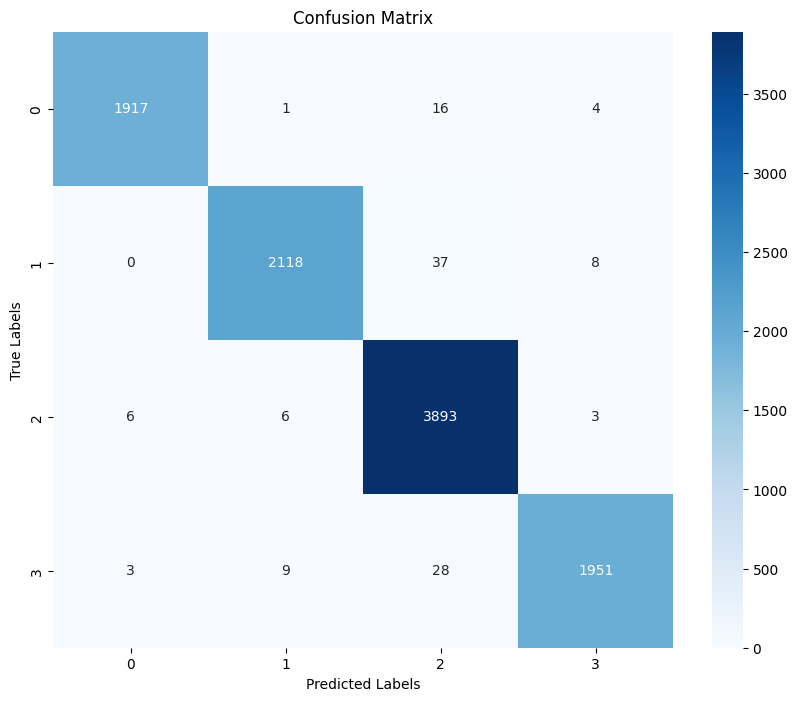

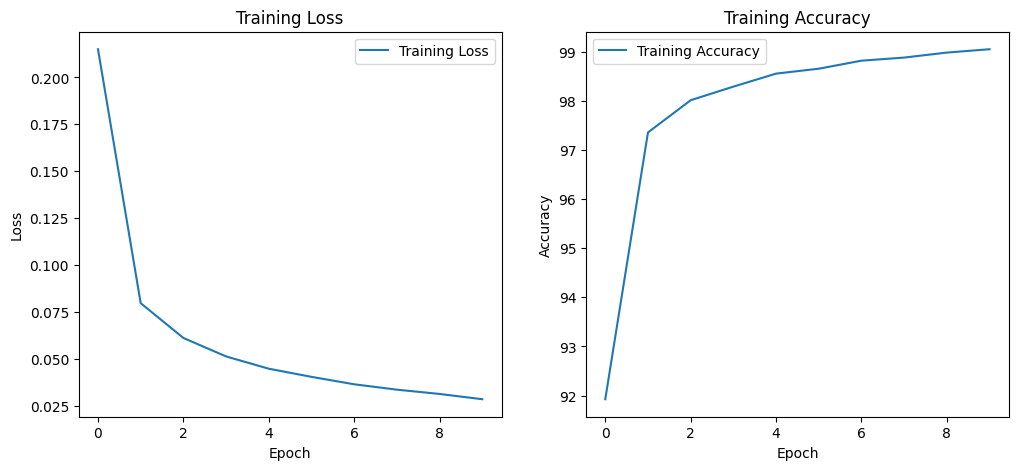

In [ ]:
optimizer_4 = optim.Adam(model_4.parameters(), lr=0.001)
criterion_4 = nn.CrossEntropyLoss()
train_losses_4, train_accuracies_4 = train_model(model_4, train_loader_4, criterion_4, optimizer_4)
all_labels_4, all_predictions_4 = evaluate_model(model_4, test_loader_4)
plot_results(all_labels_4, all_predictions_4, train_losses_4, train_accuracies_4)

In [ ]:
summary(model_4,(1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             800
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3            [-1, 8, 14, 14]           3,208
         MaxPool2d-4              [-1, 8, 7, 7]               0
            Conv2d-5              [-1, 4, 4, 4]             292
         AvgPool2d-6              [-1, 4, 2, 2]               0
            Linear-7                    [-1, 4]              68
Total params: 4,368
Trainable params: 4,368
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.02
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


# Visualize Layer Output


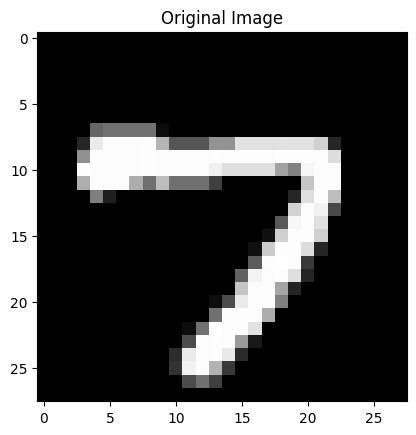

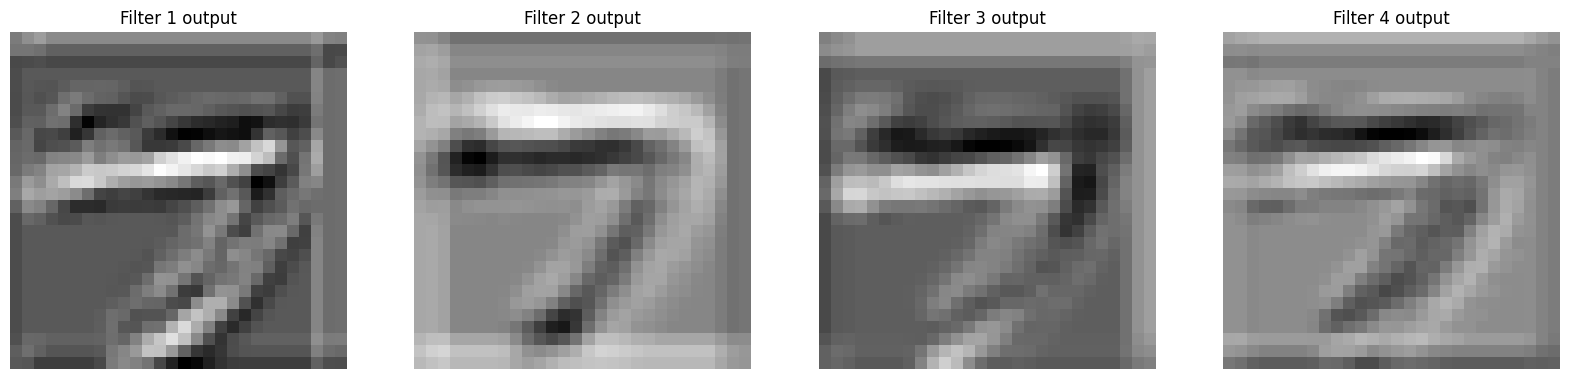

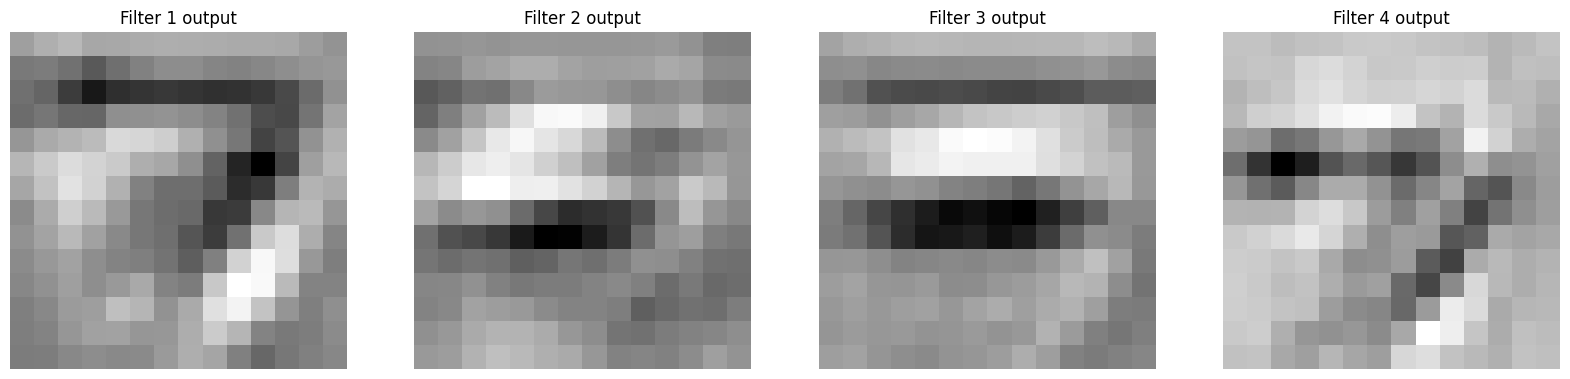

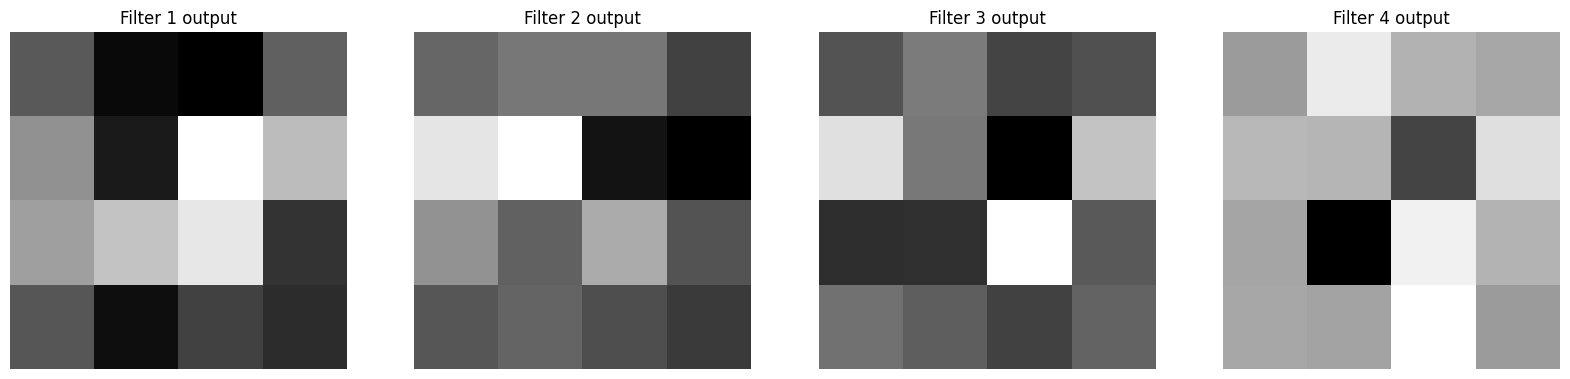

In [ ]:
sample_image, _ = next(iter(train_loader_4))
sample_image = sample_image[0:1]

plt.imshow(sample_image[0][0], cmap='gray')
plt.title("Original Image")
plt.show()

visualize_layer_output(model_4, 'conv1', sample_image)
visualize_layer_output(model_4, 'conv2', sample_image)
visualize_layer_output(model_4, 'conv3', sample_image)

#Error Analysis

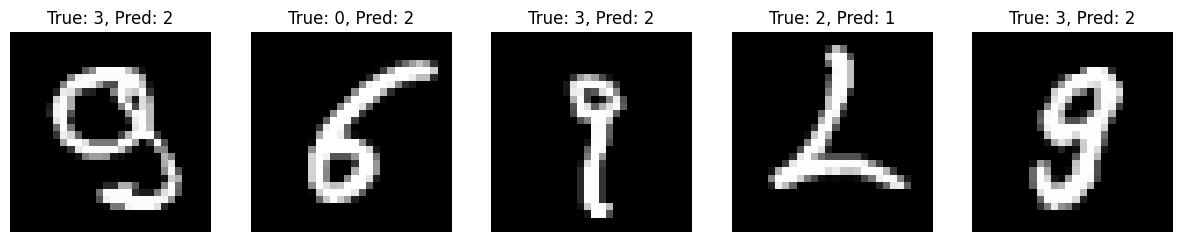

In [ ]:
error_analysis(all_predictions_4, all_labels_4)


# Feature Map Activation Across Layers


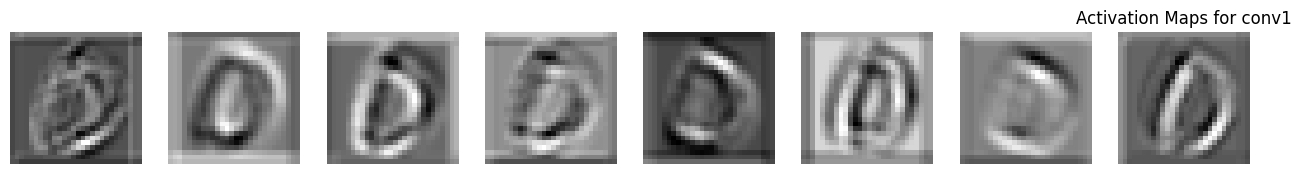

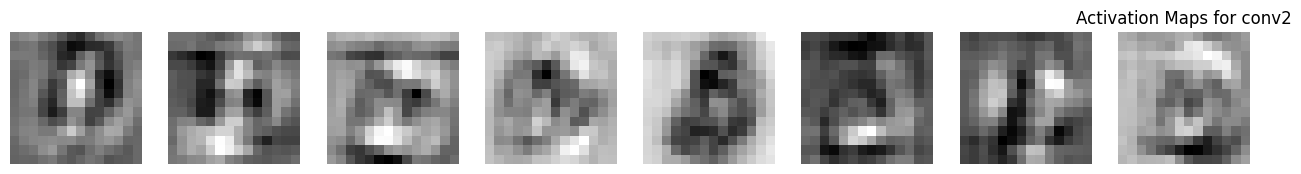

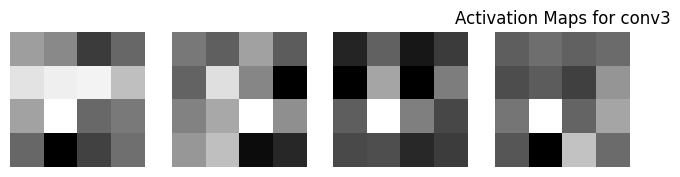

In [ ]:
visualize_activation_maps(model_4, sample_image)


#T-SNE Visualization of Feature Representations

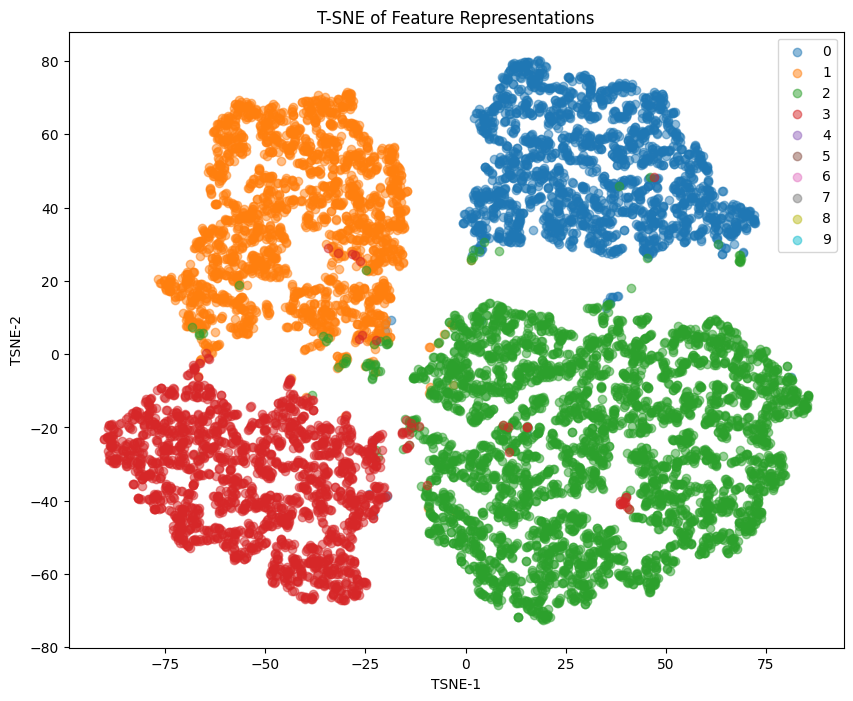

In [ ]:
features, labels = extract_features(test_loader_4, model_4)

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
for label in range(10):
    indices = [i for i, l in enumerate(labels) if l == label]
    current_tsne = tsne_results[indices, :]
    plt.scatter(current_tsne[:, 0], current_tsne[:, 1], label=str(label), alpha=0.5)
plt.legend()
plt.title('T-SNE of Feature Representations')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.show()

# Bonus

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

augmentation_transform = transforms.Compose([
    transforms.RandomRotation(10),  # Rotate the image by up to 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translate the image
    transforms.ColorJitter(brightness=0.5), # Decrease Brightness
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset_b = datasets.MNIST(root='/content/drive/MyDrive/DL/', train=True, transform=augmentation_transform, download=False)
test_dataset_b = datasets.MNIST(root='/content/drive/MyDrive/DL/', train=False, transform=transform, download=False)

train_loader_b = DataLoader(dataset=train_dataset_b, batch_size=20, shuffle=True)
test_loader_b = DataLoader(dataset=test_dataset_b, batch_size=20, shuffle=False)


Epoch [1/10], Loss: 0.5883, Accuracy: 80.63%
Epoch [2/10], Loss: 0.2517, Accuracy: 92.39%
Epoch [3/10], Loss: 0.2047, Accuracy: 93.84%
Epoch [4/10], Loss: 0.1784, Accuracy: 94.54%
Epoch [5/10], Loss: 0.1599, Accuracy: 95.24%
Epoch [6/10], Loss: 0.1470, Accuracy: 95.49%
Epoch [7/10], Loss: 0.1358, Accuracy: 95.81%
Epoch [8/10], Loss: 0.1296, Accuracy: 96.07%
Epoch [9/10], Loss: 0.1217, Accuracy: 96.25%
Epoch [10/10], Loss: 0.1173, Accuracy: 96.42%
Test Accuracy: 98.37%


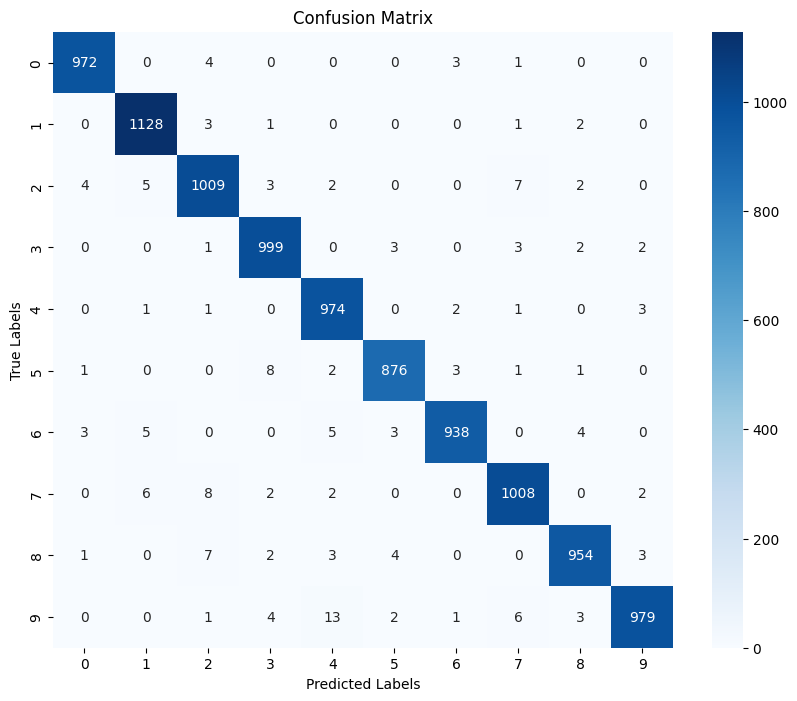

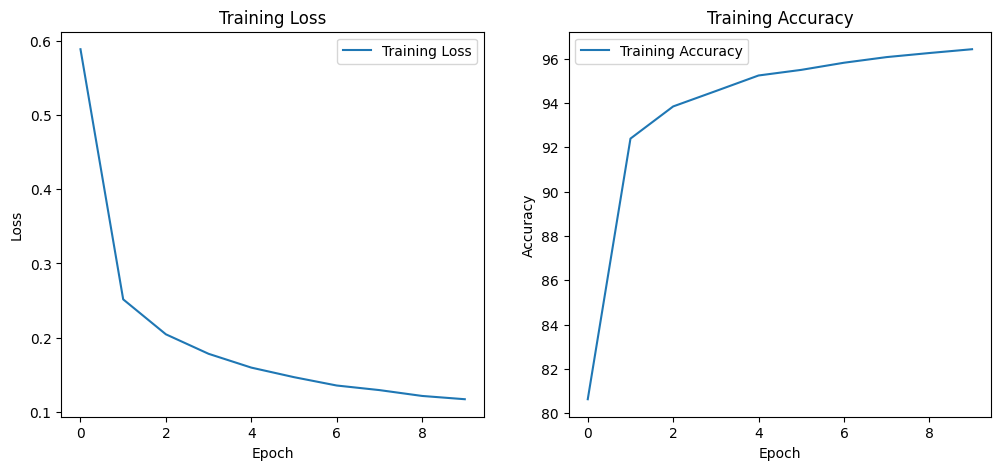

In [ ]:
model_b = CNN().to(device)
criterion_b = nn.CrossEntropyLoss()
optimizer_b = optim.Adam(model_b.parameters(), lr=0.001)
train_losses_b, train_accuracies_b = train_model(model_b, train_loader_b, criterion_b, optimizer_b)
all_labels_b, all_predictions_b = evaluate_model(model_b, test_loader_b)
plot_results(all_labels_b, all_predictions_b, train_losses_b, train_accuracies_b)


#DropOut

Epoch [1/30], Loss: 1.0504, Accuracy: 63.56%
Epoch [2/30], Loss: 0.6617, Accuracy: 78.36%
Epoch [3/30], Loss: 0.5685, Accuracy: 81.55%
Epoch [4/30], Loss: 0.5179, Accuracy: 83.00%
Epoch [5/30], Loss: 0.4814, Accuracy: 84.45%
Epoch [6/30], Loss: 0.4657, Accuracy: 84.95%
Epoch [7/30], Loss: 0.4475, Accuracy: 85.59%
Epoch [8/30], Loss: 0.4388, Accuracy: 85.71%
Epoch [9/30], Loss: 0.4289, Accuracy: 86.16%
Epoch [10/30], Loss: 0.4163, Accuracy: 86.66%
Epoch [11/30], Loss: 0.4165, Accuracy: 86.79%
Epoch [12/30], Loss: 0.4072, Accuracy: 87.01%
Epoch [13/30], Loss: 0.4016, Accuracy: 87.19%
Epoch [14/30], Loss: 0.3991, Accuracy: 87.29%
Epoch [15/30], Loss: 0.3843, Accuracy: 87.77%
Epoch [16/30], Loss: 0.3790, Accuracy: 88.01%
Epoch [17/30], Loss: 0.3847, Accuracy: 87.94%
Epoch [18/30], Loss: 0.3757, Accuracy: 88.11%
Epoch [19/30], Loss: 0.3741, Accuracy: 88.07%
Epoch [20/30], Loss: 0.3680, Accuracy: 88.33%
Epoch [21/30], Loss: 0.3658, Accuracy: 88.38%
Epoch [22/30], Loss: 0.3625, Accuracy: 88.7

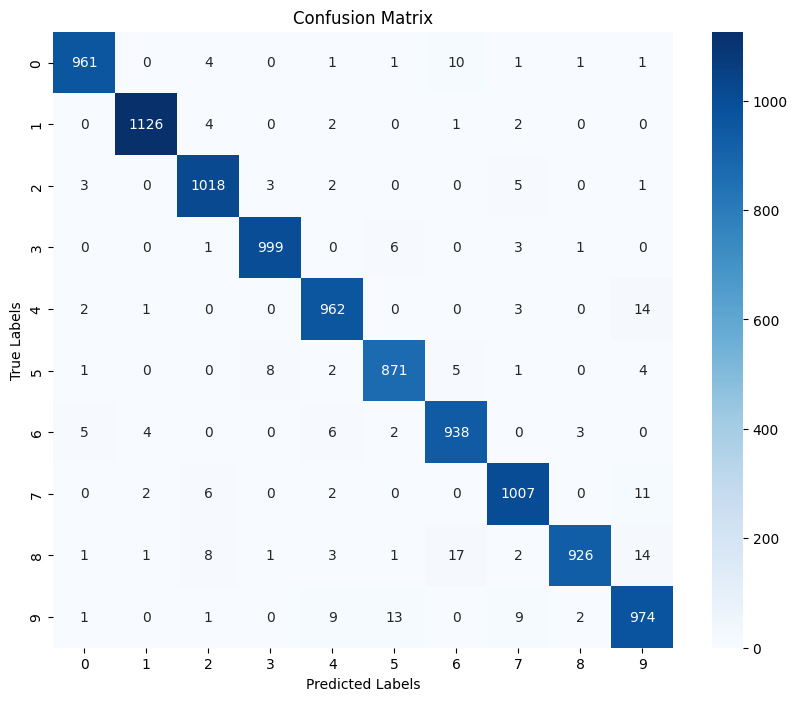

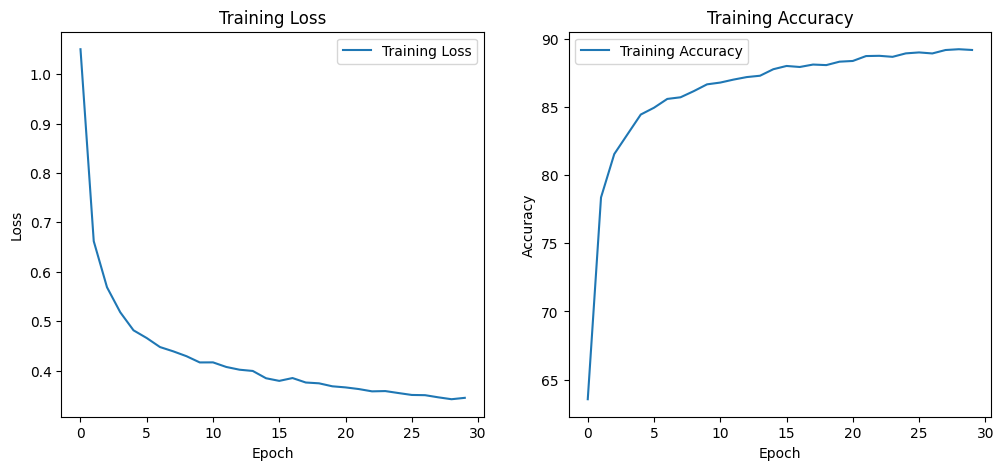

In [ ]:
class CNN_b1Class(CNN):
    def __init__(self,dropout_rate=0.3):
        super(CNN_b1Class, self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
    def forward(self, x):
        x = self.conv_forward(x)
        x = x.view(-1, self._to_linear)
        x = self.dropout(x)
        x = self.fc(x)
        return x


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
augmentation_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.5), # Decrease Brightness
    transforms.RandomRotation(10),  # Rotate the image by up to 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translate the image

    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset_b1 = datasets.MNIST(root='/content/drive/MyDrive/DL/', train=True, transform=augmentation_transform, download=False)
test_dataset_b1 = datasets.MNIST(root='/content/drive/MyDrive/DL/', train=False, transform=transform, download= False)

train_loader_b1 = DataLoader(dataset=train_dataset_b1, batch_size=20, shuffle=True)
test_loader_b1 = DataLoader(dataset=test_dataset_b1, batch_size=20, shuffle=False)

model_b1 = CNN_b1Class().to(device)
criterion_b1 = nn.CrossEntropyLoss()
optimizer_b1 = optim.Adam(model_b1.parameters(), lr=0.001)
train_losses_b1, train_accuracies_b1 = train_model(model_b1, train_loader_b1, criterion_b1, optimizer_b1, 30)
all_labels_b1, all_predictions_b1 = evaluate_model(model_b1, test_loader_b1)
plot_results(all_labels_b1, all_predictions_b1, train_losses_b1, train_accuracies_b1)




In [ ]:
summary(model_b1, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             800
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3            [-1, 8, 14, 14]           3,208
         MaxPool2d-4              [-1, 8, 7, 7]               0
            Conv2d-5              [-1, 4, 4, 4]             292
         AvgPool2d-6              [-1, 4, 2, 2]               0
           Dropout-7                   [-1, 16]               0
            Linear-8                   [-1, 10]             170
Total params: 4,470
Trainable params: 4,470
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.02
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


# Batch Normalization

Epoch [1/15], Loss: 0.3720, Accuracy: 91.82%
Epoch [2/15], Loss: 0.0944, Accuracy: 97.29%
Epoch [3/15], Loss: 0.0729, Accuracy: 97.72%
Epoch [4/15], Loss: 0.0620, Accuracy: 98.05%
Epoch [5/15], Loss: 0.0552, Accuracy: 98.30%
Epoch [6/15], Loss: 0.0490, Accuracy: 98.45%
Epoch [7/15], Loss: 0.0450, Accuracy: 98.53%
Epoch [8/15], Loss: 0.0408, Accuracy: 98.71%
Epoch [9/15], Loss: 0.0392, Accuracy: 98.74%
Epoch [10/15], Loss: 0.0356, Accuracy: 98.86%
Epoch [11/15], Loss: 0.0349, Accuracy: 98.91%
Epoch [12/15], Loss: 0.0323, Accuracy: 98.90%
Epoch [13/15], Loss: 0.0310, Accuracy: 99.00%
Epoch [14/15], Loss: 0.0287, Accuracy: 99.11%
Epoch [15/15], Loss: 0.0276, Accuracy: 99.10%
Test Accuracy: 98.66%


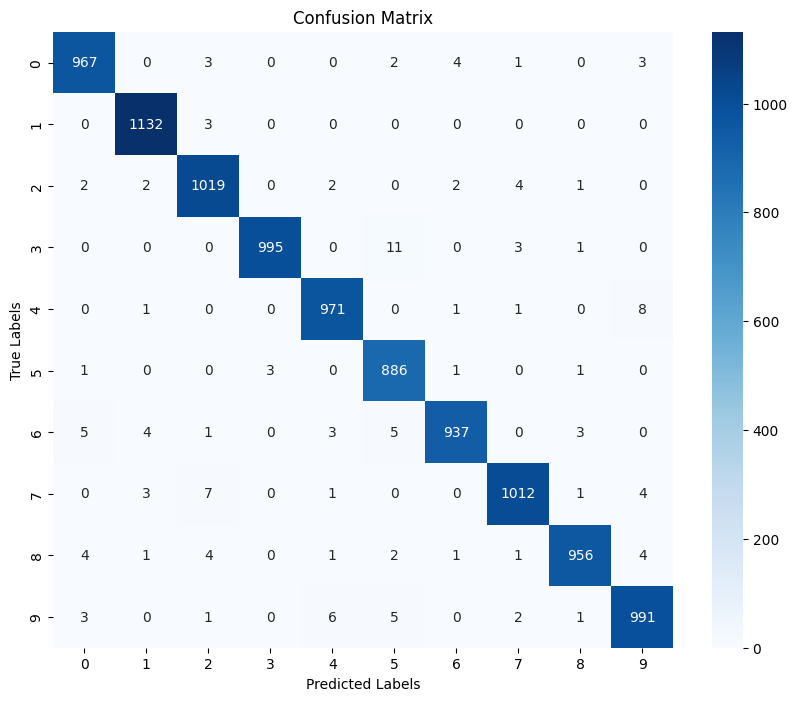

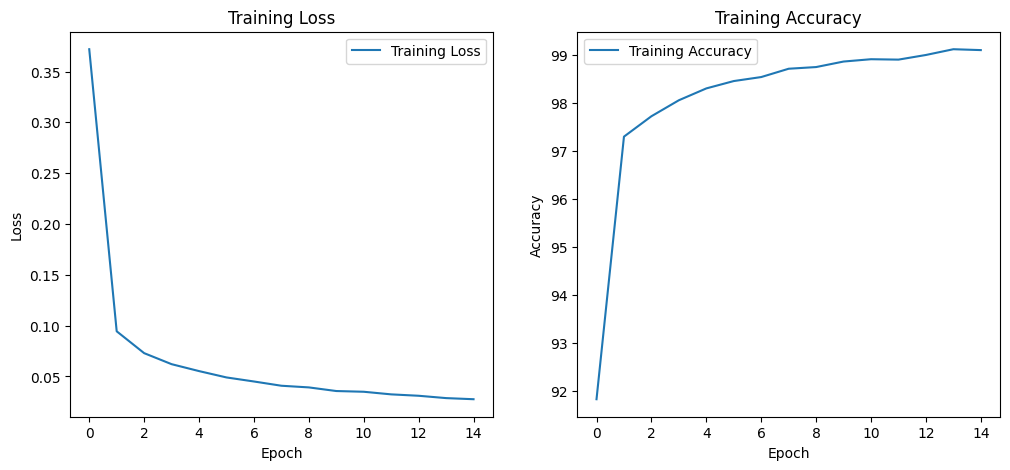

In [ ]:
class CNN_b2Class(nn.Module):
    def __init__(self):
        super(CNN_b2Class, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization for conv1
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(8)   # Batch normalization for conv2
        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(4)   # Batch normalization for conv3

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

        self._to_linear = None
        self._calculate_to_linear_size()

        self.fc = nn.Linear(self._to_linear, 10)

    def _calculate_to_linear_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)
            output = self.conv_forward(dummy_input)
            self._to_linear = output.numel()

    def conv_forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.avgpool(x)
        return x

    def forward(self, x):
        x = self.conv_forward(x)
        x = x.view(-1, self._to_linear)  # Flatten the tensor
        x = self.fc(x)
        return x
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset_b2 = datasets.MNIST(root='/content/drive/MyDrive/DL/', train=True, transform=transform, download=False)
test_dataset_b2 = datasets.MNIST(root='/content/drive/MyDrive/DL/', train=False, transform=transform, download= False)

train_loader_b2 = DataLoader(dataset=train_dataset_b2, batch_size=20, shuffle=True)
test_loader_b2 = DataLoader(dataset=test_dataset_b2, batch_size=20, shuffle=False)

model_b2 = CNN_b2Class().to(device)
criterion_b2 = nn.CrossEntropyLoss()
optimizer_b2 = optim.Adam(model_b2.parameters(), lr=0.001)
train_losses_b2, train_accuracies_b2 = train_model(model_b2, train_loader_b2, criterion_b2, optimizer_b2, 15)
all_labels_b2, all_predictions_b2 = evaluate_model(model_b2, test_loader_b2)
plot_results(all_labels_b2, all_predictions_b2, train_losses_b2, train_accuracies_b2)